In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')

# **Read CSV file and choose 'Date" as index**

In [3]:
df_stock= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSFT_historical_data_yfinance.csv')
target= 'Close'
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.index= df_stock['Date']
print(df_stock.dtypes)

Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Date      datetime64[ns]
dtype: object


In [4]:
df_stock.head()

,Open,High,Low,Close,Volume,Date
Date,,,,,,
2013-12-13,31.509763,31.535026,30.836118,30.895061,40066100,2013-12-13
2013-12-16,30.928732,31.156088,30.768743,31.063461,31734200,2013-12-16
2013-12-17,31.105562,31.248713,30.591910,30.751900,45687700,2013-12-17
2013-12-18,30.617180,30.819271,29.918271,30.802433,63192100,2013-12-18
2013-12-19,30.743483,30.777166,30.381401,30.524549,34160100,2013-12-19


# **VISUALIZING DATASET**

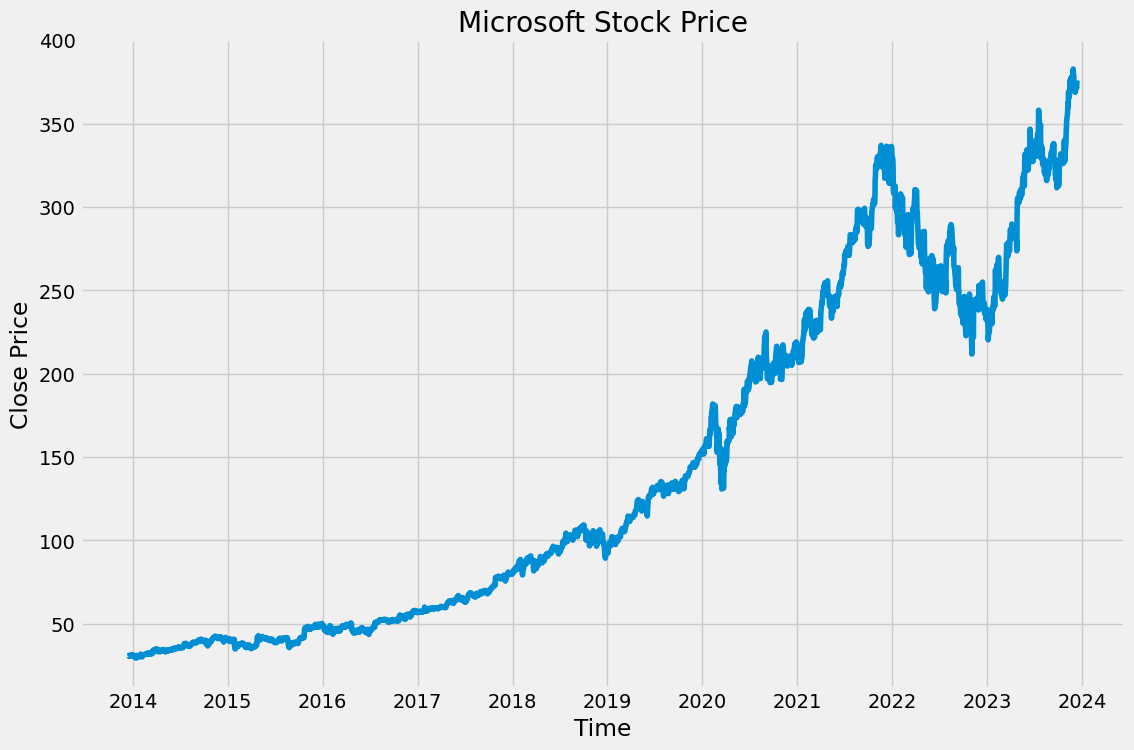

In [5]:
plt.figure(figsize=(12,8))
plt.title('Microsoft Stock Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.plot(df_stock[target])
plt.show()

# **SPLIT DATASET INTO TRAIN SET, TEST SET**

In [6]:
# Create label and feature
x = df_stock.drop([target, 'Date'], axis=1)
y=df_stock[target]
# Split train set, validation set and test set
x_train, x_temp, y_train, y_temp= train_test_split(x,y, train_size=0.88, shuffle= False)
x_val, x_test, y_val, y_test= train_test_split(x_temp,y_temp, train_size=251/303, shuffle= False)

# **USING GRIDSEARCHCV TO FIND THE BEST PARAMETER TO TRAIN**

In [7]:
# Parameter
param_grid = {
    'reg__C': [0.1, 1, 10],
    'reg__kernel': ['linear', 'rbf', 'poly'],
    'reg__epsilon': [0.1, 0.2, 0.5]
}

In [9]:
# Scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', SVR())
])

In [10]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg', SVR())]),
             param_grid={'reg__C': [0.1, 1, 10],
                         'reg__epsilon': [0.1, 0.2, 0.5],
                         'reg__kernel': ['linear', 'rbf', 'poly']},
             scoring='neg_mean_squared_error')

In [11]:
# Print best parameter for SVR
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'reg__C': 10, 'reg__epsilon': 0.1, 'reg__kernel': 'linear'}


In [12]:
# Choose the best parameter for predictinh
best_model = grid_search.best_estimator_

# **EVALUATION THE MODEL**

In [13]:
# Calculate MAE, MSE and R2 on the validation set
y_val_predict = best_model.predict(x_val)
mae_val = mean_absolute_error(y_val, y_val_predict)
mse_val = mean_squared_error(y_val, y_val_predict)
r2_val = r2_score(y_val, y_val_predict)
print(f'Mean Absolute Error (Validation): {mae_val}')
print(f'Mean Squared Error (Validation): {mse_val}')
print(f'R-squared (Validation): {r2_val}')

Mean Absolute Error (Validation): 1.5033350820951448
Mean Squared Error (Validation): 3.5279336224340625
R-squared (Validation): 0.9979319003706052


In [14]:
# Calculate MAE, MSE and R2 on the test set
y_test_predict = best_model.predict(x_test)
mae_test = mean_absolute_error(y_test, y_test_predict)
mse_test = mean_squared_error(y_test, y_test_predict)
r2_test = r2_score(y_test, y_test_predict)

print(f'Mean Absolute Error (Test): {mae_test}')
print(f'Mean Squared Error (Test): {mse_test}')
print(f'R-squared (Test): {r2_test}')

Mean Absolute Error (Test): 1.437687679923073
Mean Squared Error (Test): 3.0421914446610367
R-squared (Test): 0.9936298255658363


In [17]:
# Create a Dataframe to compare the prediction and the actual
comparison_df = pd.DataFrame({'Date': x_val.index,
                               'Actual': y_val.values,
                               'Predicted': y_val_predict})
comparison_df = comparison_df.sort_values(by='Date')

comparison_df.set_index('Date', inplace=True)
comparison_df

,Actual,Predicted
Date,,
2022-09-30,230.204285,233.583798
2022-10-03,237.953552,236.197261
2022-10-04,245.999344,245.644565
2022-10-05,246.315613,244.989300
2022-10-06,243.933533,245.653360
...,...,...
2023-09-25,316.896820,316.039555
2023-09-26,311.507751,312.060493
2023-09-27,312.156433,311.625487


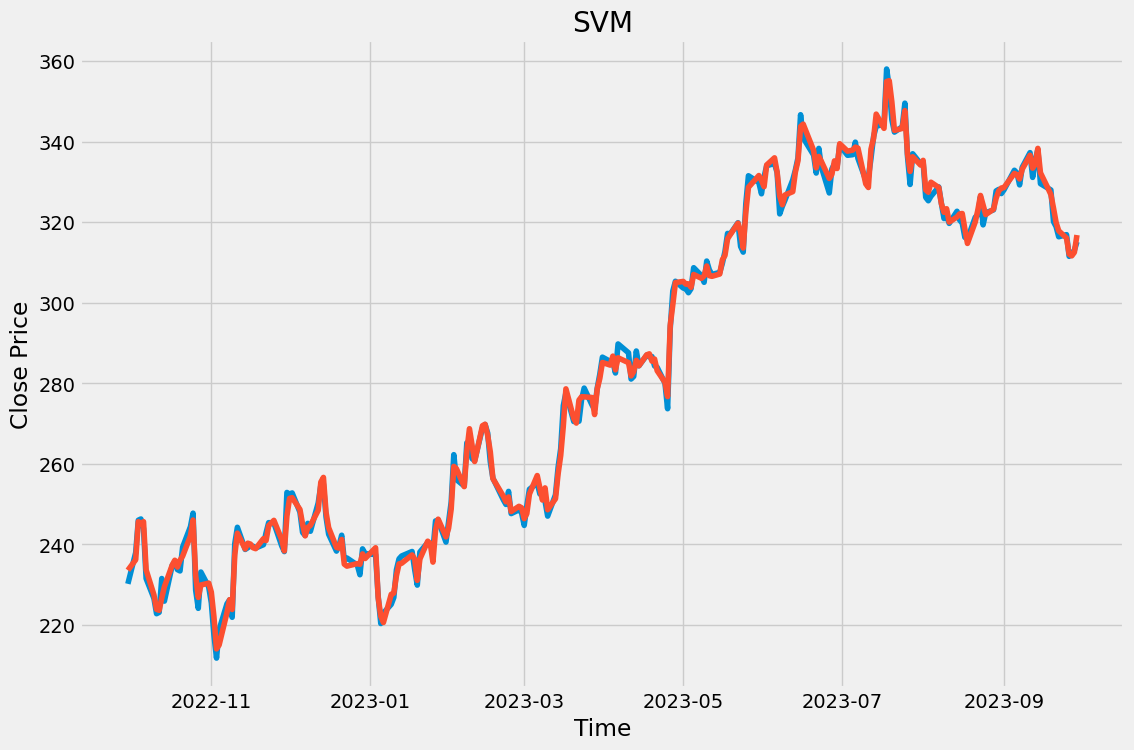

In [18]:
# Compare with graph
plt.figure(figsize=(12,8))
plt.title('SVM')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.plot(comparison_df[['Actual', 'Predicted']])
plt.show()